# [tensorflow](https://www.tensorflow.org)の紹介

*170614 Masahiro Rikiso*

---

まずは[これ](https://www.tensorflow.org/get_started/mnist/beginners) だけ読んでればOK

* [1. データの読み込み](#1.-データの読み込み)
* [2. 学習用データの作成](#2.-学習用データの作成)
* [3. 機械学習モデルの作成](#3.-機械学習モデルの作成)
* [4. モデルの評価](#4.-モデルの評価)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

## 1. データの読み込み

下の2行で読み込める。覚える必要なし。

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2. 学習用データの作成

tensorflowAPIで読み込んで時点で、train-validation-test-splitが自動的にされてます。

<img src="https://www.tensorflow.org/images/mnist-train-xs.png" width=300>

<img src="https://www.tensorflow.org/images/mnist-train-ys.png" width=300>

In [4]:
X_train = mnist.train.images
y_train = mnist.train.labels

X_train.shape, y_train.shape

((55000, 784), (55000, 10))

In [5]:
X_val = mnist.validation.images
y_val = mnist.validation.labels

X_val.shape, y_val.shape

((5000, 784), (5000, 10))

In [6]:
X_test = mnist.test.images
y_test = mnist.test.labels

X_test.shape, y_test.shape

((10000, 784), (10000, 10))

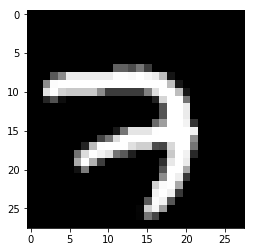

In [7]:
img_sample = X_train[0].reshape(28,28)
plt.imshow(img_sample, cmap='gray');

## 3. 機械学習モデルの作成

隠れ層 2層のDNNを組んでみます。

In [8]:
# パラメータ（ほんとは試行錯誤で決める）
learning_rate = 0.001
training_epochs = 15
batch_size = 128
display_step = 1

n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features

In [9]:
# こっちはデータセットで自動的に決まるパラメータ
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

`tf.placeholder`: 入力、出力など「定数のいれもの」を作る

In [10]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

`tf.Variable`: 重みやバイアスなど「変数のいれもの」を作る

In [11]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

2層ニューラルネットを定義します。

Input(784) -- FC(256, ReLU) -- FC(256, ReLU) -- Output(10, Softmax)

In [12]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

* 目的関数: cross_entropy
* 最適化手法: adam

を定義

In [13]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

初期化メソッドを定義（tensorflowのおまじないみたいなもん。あんま気にしなくていい）

In [14]:
# Initializing the variables
init = tf.global_variables_initializer()

ここから、実際の学習コード。

`with tf.Session() as sess:` でくくって、

その中で

1. 初期化: `sess.run(init)`
2. 学習: `sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})`

する。 2. 学習のところは forループで何回も回す。

仕組みは、sess.run(arg)と書くと、argを得るのに必要な計算が実行されて、返り値として計算されたargが返る。

In [15]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), "loss(cross_entropy)=", \
                "{:.9f}".format(avg_cost)
    print "Optimization Finished!"

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print "Accuracy(Test Dataset):", accuracy.eval({x: mnist.test.images, y: mnist.test.labels})

Epoch: 0001 loss(cross_entropy)= 188.736816755
Epoch: 0002 loss(cross_entropy)= 48.096417374
Epoch: 0003 loss(cross_entropy)= 30.611777298
Epoch: 0004 loss(cross_entropy)= 21.902288404
Epoch: 0005 loss(cross_entropy)= 16.086965740
Epoch: 0006 loss(cross_entropy)= 12.228513490
Epoch: 0007 loss(cross_entropy)= 9.621035945
Epoch: 0008 loss(cross_entropy)= 7.439101037
Epoch: 0009 loss(cross_entropy)= 5.807910895
Epoch: 0010 loss(cross_entropy)= 4.431958169
Epoch: 0011 loss(cross_entropy)= 3.434407504
Epoch: 0012 loss(cross_entropy)= 2.748598935
Epoch: 0013 loss(cross_entropy)= 2.123592254
Epoch: 0014 loss(cross_entropy)= 1.614521905
Epoch: 0015 loss(cross_entropy)= 1.288336359
Optimization Finished!
Accuracy(Test Dataset): 0.9409


>参考リソース: http://nbviewer.jupyter.org/github/aymericdamien/TensorFlow-Examples/tree/master/notebooks/